In [1]:
%pylab inline
import sys

sys.path.insert(0, '..')

import torch
from torch.autograd import Variable
from torch import FloatTensor
from skimage import data
import skimage
import matplotlib.pyplot as plt
import time
import os
import copy


from utils.image_utils import check_nan_tensor
from datasets import OnTheFlyDataset
from data_generation.pipeline import ImageDegradationPipeline


def numpy2tensor(arr):
    if len(arr.shape) < 3:
        arr = np.expand_dims(arr, -1)
    return FloatTensor(arr).permute(2, 0, 1).unsqueeze(0).float() / 255.0

def tensor2numpy(t, idx=None):
    t = torch.clamp(t, 0, 1)
    if idx is None:
        t = t[0, ...]
    else:
        t = t[idx, ...]
    return (t.permute(1, 2, 0).cpu().squeeze().numpy() * 255.0).astype('uint8')

def center_crop_tensor_mosaic(tensor, w, h, phase=0):
    tw = tensor.size(-1)
    th = tensor.size(-2)
    if tw < w or th < h:
        raise RuntimeError("Crop size is larger than image size.")
    h0 = int((th - h) / 2)
    w0 = int((tw - w) / 2)
    # so that it align with mosaick pattern
    h0 = h0 - (h0 % 2)
    w0 = w0 - (w0 % 2)
    h0 += phase % 2
    w0 += phase // 2
    h1 = h0 + h
    w1 = w0 + w
    return tensor[..., h0:h1, w0:w1]

input_file = '../samples/iphone7_dng.npy'
target_file = '../samples/iphone7_jpg.npy'

Populating the interactive namespace from numpy and matplotlib


In [2]:
input_dng = FloatTensor(np.load(input_file))
target_jpg = FloatTensor(np.load(target_file))

In [3]:


test_data_configs = {
    "exp_adjustment": 2.0,
    "exposure_correction": False,
    "use_motion_blur": False,
    "use_chromatic_aberration": False,
    "chromatic_aberration": 0.0,
    "read_noise_sigma": 0.0,
    "poisson_k": 0.0,
    "motion_blur": 0.0,
    "motion_blur_dir": 0.0,
    "denoise": True,
    "denoise_sigma_s": 8,
    "denoise_sigma_r": 0.25,
    "denoise_color_sigma_ratio": 1,
    "denoise_color_range_ratio": 0.01,
    "denoise_color_only": False,
    "denoise_guide_transform": 0.2,
    "bilateral_class": "DenoisingBilateral",
    "denoise_n_iter": 1,
    "median_before_bilateral": False,
    "use_median_denoise": True,
    "denoise_median": [[0, 1, 0], [1, 0, 1], [0, 1, 0]],
    "denoise_median_n_iter": 1,
    "demosaick": True,
    "demosaick_use_median": False,
    "demosaick_n_iter": 1,
    "demosaick_class": "AHDDemosaickingNonDifferentiable",
    "demosaicked_input": False,
    "use_unsharp_mask": True,
    "unsharp_amount": 0.25,
    "quantize": False,
    "saturation": 0.8,
    "use_wavelet": False,
    "pre_tonemap_class": "GammaCompression",
    "post_tonemap_class": "ToneCurve",
    "jpeg_compression": False,
    "jpeg_quality": 6,
    "white_balance": True,
    "repair_hotdead_pixel": False,
    "hot_px_th": 0.2,
    "idx": 0,
    "tone_curve_highlight": -0.4,
    "tone_curve_midtone": -0.4,
    "tone_curve_shadow": 0.0,
    "post_tonemap_amount": 0.2,
    "pre_tonemap_amount": 1.414,
    "white_balance_temp": 6300,
    "white_balance_tint": 0.0,
}

Using AHD Non-differentiable


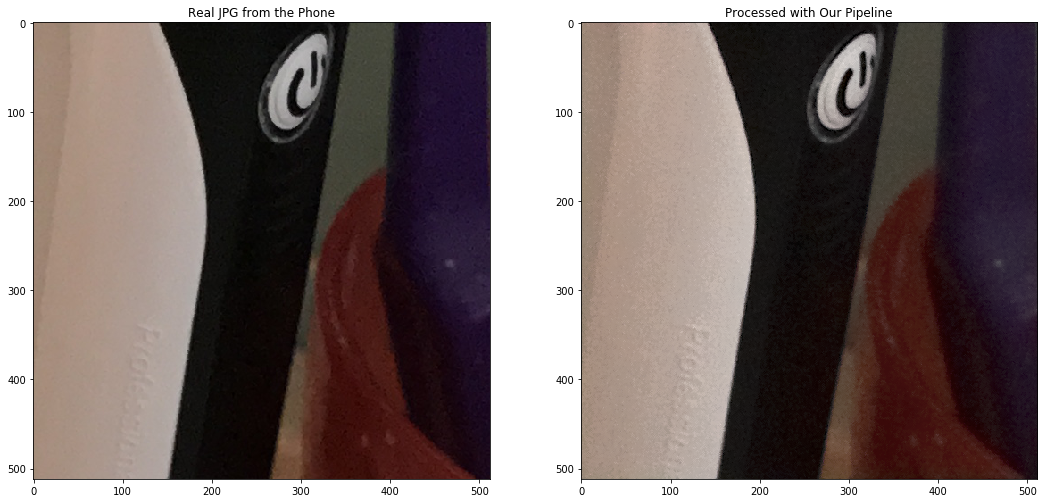

In [4]:

configs_postprocess = [
    ('sRGBGamma', {}),
]

pipeline_postprocess = ImageDegradationPipeline(configs_postprocess)

pipeline_restore, _ = OnTheFlyDataset._create_pipeline(**test_data_configs)
processed_input_dng = pipeline_restore(input_dng)

# postprocess
processed_input_dng = pipeline_postprocess(processed_input_dng)
# target_jpg = pipeline_postprocess(target_jpg)
# Convert to numpy
processed_input_dng_numpy = tensor2numpy(processed_input_dng)
target_jpg_numpy = tensor2numpy(target_jpg)

# Plotting code
plt.figure(figsize=(18, 14))

plt.subplot(121)
plt.imshow(target_jpg_numpy)
plt.title('Real JPG from the Phone')

plt.subplot(122)
plt.imshow(processed_input_dng_numpy)
plt.title('Processed with Our Pipeline')

plt.show()